# iAR package Demo - BIAR Model

In [1]:
import iar
import numpy as np
import matplotlib.pyplot as plt
print("iAR version:")
print(iar.__version__)

iAR version:
1.0.0


# Simulates from a BIAR Model

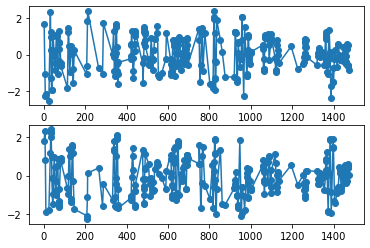

In [3]:
from iar import BIAR_sample,gentime
np.random.seed(6713)
n=300
phi1=0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIAR_sample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=0.9)
plt.subplot(211)
plt.plot(sT, y[0],"o-")
plt.subplot(212)
plt.plot(sT, y[1],"o-")
plt.show()

# Maximum Likelihood Estimation of the BIAR Model

In [7]:
from iar import BIAR_phi_kalman,BIAR_kalman
y1=np.zeros((2,len(y[0])))
y1[0]=y[0]/np.sqrt(np.var(y[0],ddof=1))
y1[1]=y[1]/np.sqrt(np.var(y[1],ddof=1))
out=BIAR_phi_kalman(x=[0.9,0.4],y1=y1[0],y2=y1[1],t=sT,yerr1=np.zeros(len(y1[0])),yerr2=np.zeros(len(y1[0])))
print(out)

-4.013318518253691


In [8]:
phi_R,phi_I,out=BIAR_kalman(y1=y1[0],y2=y1[1],sT=sT,delta1=np.zeros(len(y1[0])),delta2=np.zeros(len(y1[0])))
print(phi_R)
print(phi_I)

0.9015854003457231
0.3970596689383783


# Estimating Contemporary Correlation

In [9]:
from iar import BIAR_fit
cor,cov,yhat,xhat=BIAR_fit(x=(phi_R,phi_I),y1=y1[0],y2=y1[1],t=sT,yerr1=np.zeros(len(y1[0])),yerr2=np.zeros(len(y1[0])))
print(cor)
print(cov)

(300, 2)
0.8702085093043241
[[0.10830512 0.09204711]
 [0.09204711 0.10330579]]


# Simulates a Negatively Correlated BIAR Model

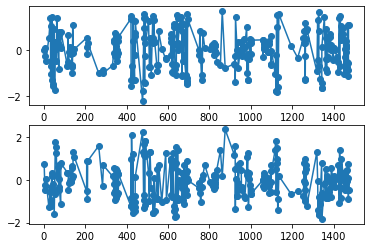

In [11]:
np.random.seed(6713)
n=300
phi1=-0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIAR_sample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=-0.9)
plt.subplot(211)
plt.plot(sT, y[0],"o-")
plt.subplot(212)
plt.plot(sT, y[1],"o-")
plt.show()

In [12]:
y1=np.zeros((2,len(y[0])))
y1[0]=y[0]/np.sqrt(np.var(y[0],ddof=1))
y1[1]=y[1]/np.sqrt(np.var(y[1],ddof=1))
phi_R,phi_I,out=BIAR_kalman(y1=y1[0],y2=y1[1],sT=sT,delta1=np.zeros(len(y1[0])),delta2=np.zeros(len(y1[0])))
print(phi_R)
print(phi_I)

-0.897708648794777
0.3933193549529725


In [13]:
cor,cov,yhat,xhat=BIAR_fit(x=(phi_R,phi_I),y1=y1[0],y2=y1[1],t=sT,yerr1=np.zeros(len(y1[0])),yerr2=np.zeros(len(y1[0])))
print(cor)
print(cov)

(300, 2)
-0.9059622562480752
[[ 0.15222865 -0.14806174]
 [-0.14806174  0.17545635]]


# Forecast with BIAR Model

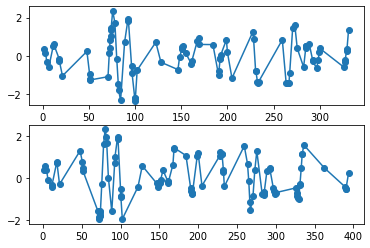

In [18]:
from iar import BIAR_LL_Smoothing
n=100
phi1=0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIAR_sample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=0.9)
n=len(sT)
p=int(0.9*n)
y0=np.copy(y)
y1=np.zeros((2,100))
y1[0]=(y0[0]-np.mean(y0[0]))/np.sqrt(np.var(y0[0],ddof=1))
y1[1]=(y0[1]-np.mean(y0[1]))/np.sqrt(np.var(y0[1],ddof=1))
boolean1=np.isin(np.arange(n),np.arange(p,n))
y1[0][np.where(boolean1)[0]]=np.nan
plt.subplot(211)
plt.plot(sT, y1[0],"o-")
plt.subplot(212)
plt.plot(sT, y1[1],"o-")
plt.show()